# Library Import

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal
from scipy.fft import fftshift
import math
import mne
base_dir = os.getcwd()
print(f'current directory: {base_dir}')
dataset_dir = os.path.join(base_dir, 'datasets')
print(f'datasets directory: {dataset_dir}')

current directory: /Users/delphia/Desktop/final_project
datasets directory: /Users/delphia/Desktop/final_project/datasets


# Define utility functions

In [2]:
recording_len = 7680
freq = 128
total_time = recording_len // freq
print(f'the recording is {total_time} seconds long and has total {recording_len} values')

the recording is 60 seconds long and has total 7680 values


In [37]:
def read_A_dataset(path, case_str):
  case_path = os.path.join(path, case_str)
  subjects_list = []
  for filename in os.listdir(case_path):
    with open(os.path.join(case_path, filename), 'r') as f:
      lines = f.readlines()
      subjects_list.append(lines)
  return subjects_list

# -----------------------------------------
def convert_to_numbers(sub_list):
  new_list = []
  for sub in sub_list:
    new_list.append([float(value) for value in sub])
  return new_list

# -----------------------------------------
def list_segments(lst, segments=16):
  arr = np.array(lst)
  return np.array_split(np.array(arr), segments)


# --------------------------------------------
def divide_to_channels(subjects_list, segments=16):
  return [list_segments(subject, segments) for subject in subjects_list]


# ----------------------------------------------
def log_data_shapes(sch, norm):
  return {
 'sch': (len(sch), len(sch[0]), sch[0][0].shape),
 'norm': (len(norm), len(norm[0]), norm[0][0].shape)}

def create_spectrograms(eeg_data, fs=128, nperseg=256, noverlap=128):
    """
    Create spectrograms from EEG channel data
    
    Parameters:
    -----------
    eeg_data : array-like
        EEG channel data with shape (7680,)
    fs : int
        Sampling frequency (128 Hz)
    nperseg : int
        Length of each segment for STFT
    noverlap : int
        Number of points to overlap between segments
    
    Returns:
    --------
    f : array
        Frequency bins
    t : array
        Time points
    Sxx : 2D array
        Spectrogram data (power spectral density)
    """
    f, t, Sxx = signal.spectrogram(eeg_data, fs=fs, nperseg=nperseg, 
                                  noverlap=noverlap, scaling='density')
    return f, t, Sxx

def plot_spectrogram(f, t, Sxx, channel_name=None, plot_title=None):
    """
    Plot a spectrogram with no axes for CNN processing
    """
    plt.figure(figsize=(4, 4))
    plt.axis('off')  # Turn off all axes
    
    # Plot the spectrogram
    plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
    
    # Set limits to ensure it shows 60 seconds
    plt.xlim(0, 60)
    
    # Optional title
    if channel_name and plot_title:
        plt.title(f"{plot_title} - Channel: {channel_name}")
    elif channel_name:
        plt.title(f"Channel: {channel_name}")
    elif plot_title:
        plt.title(plot_title)
    
    plt.tight_layout()
    plt.show()

In [38]:
colors = ['black', 'darkorange', 'blue', 'red', 'cyan', 'limegreen', 'dodgerblue', 'violet', 'slateblue', 'yellow',
          'black', 'darkorange', 'blue', 'red', 'cyan', 'limegreen', 'dodgerblue', 'violet', 'slateblue', 'yellow']

channels_16 = ['F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4',
               'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

def plot_signals(data, subject_index=0, n_channels=16):
  fig = plt.figure(figsize=(20, 10), dpi=100)
  gs = gridspec.GridSpec(n_channels, 1)

  for i in range(0, n_channels):
    ax = plt.subplot(gs[i])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    line, = ax.plot(data[subject_index][i], color=colors[i])
    ax.set_yticklabels([])
    ax.set_ylabel(f'{channels_16[i]}')
    plt.xlim([0, recording_len])

  # remove vertical gap between subplots
  plt.subplots_adjust(hspace=.0)
  plt.show()

# Spectrograms data

In [39]:
norm_raw_data = convert_to_numbers(read_A_dataset(dataset_dir, 'norm'))
sch_raw_data = convert_to_numbers(read_A_dataset(dataset_dir, 'sch'))
print(f'no. subjects = norm: {len(norm_raw_data)}, sch:{len(sch_raw_data)}')
sch_channels = divide_to_channels(sch_raw_data)
norm_channels = divide_to_channels(norm_raw_data)
print('shapes: ', log_data_shapes(sch_channels, norm_channels))

no. subjects = norm: 39, sch:45
shapes:  {'sch': (45, 16, (7680,)), 'norm': (39, 16, (7680,))}


In [40]:
f,t,Sxx = create_spectrograms(sch_channels[0][1])

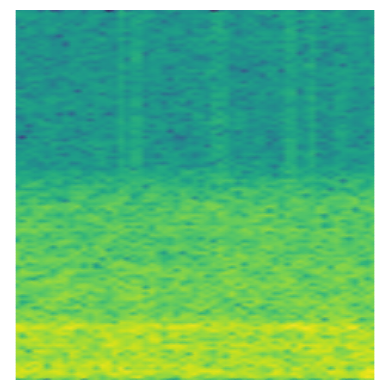

In [41]:
plot_spectrogram(f, t, Sxx)

In [16]:
# print("\n16 channel plot of one schizophernic subject")
# plot_signals(sch_channels,0)
# print("\n16 channel plot of one healthy subject ")
# plot_signals(norm_channels, 2)